In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import numpy as np
import torch
torch.manual_seed(12)
torch.cuda.manual_seed(12)
torch.cuda.manual_seed_all

dtype = torch.float
device = torch.device("cuda:0")


In [2]:
import sys

In [3]:
sys.path.append('/u/wangnisn/devel/machine_learning_kinetics/ml_kinetics')

In [4]:
from mlk import learning

# Set up model

In [5]:
vortex = {'eqn_type':'vortex',
        'fcn':'exp(-1/2*(x-cos(t))**2-1/2*(y-sin(t))**2)',
        'domain':{'x':[-2,2],'y':[-2,2],'t':[0,2]},
        
        'err_vec':[0,0,0,1,-1,0,0]}

u_t,u_x,u_y,u,x,y = sympy.symbols('u_t u_x u_y u x y')

dictionary = (u_x,u_y,x*u_x,y*u_x,x*u_y,y*u_y,u)
vortex['dictionary'] = dictionary
pde = vortex
domain =pde['domain']
fcn = pde['fcn']
n_points = 50000
x = sympy.symbols([x for x in domain.keys()])
u_exact = sympy.lambdify(x,sympy.sympify(fcn),'numpy')
inputs = {}
for key in domain.keys():
    min_d = domain[key][0]
    max_d = domain[key][1]
    #iputs[key] = ((max_d-min_d)*torch.rand((n_points,1),device=device,dtype=dtype,requires_grad=True)+min_d)
    tt = np.random.uniform(min_d,max_d,(n_points,1))
    inputs[key] = torch.tensor(tt,device=device,dtype=dtype,requires_grad=True)
u_exact = sympy.lambdify(x,sympy.sympify(fcn),'numpy')
u = u_exact(*[i.detach().cpu() for i in inputs.values()])
pde = {}
u = u.type(dtype).to(device)
pde['inputs'] = inputs

In [6]:
params = {'n_epochs':10000,
          'alpha_pde_start':10,
           'alpha_pde_end':0.001,
           'alpha_l1':1e-5, 
          'warmup_nsteps':500,
          'linearRegInterval':5,
          'linearRegression':True,
          'width':50,
          'layers':8,
          'lr':0.002,
          'update_coef_in_dl':False,
          'logfile':'alpha_decrease2.txt'}

model = learning(inputs=inputs, u=u, dictionary=dictionary,**params)


Epoch:    0,  Loss u: 1.369e-01, Loss pde: 9.829e-04, Loss_norm: 7.488e+00, Loss tot: 1.369e-01
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:   50,  Loss u: 1.584e-02, Loss pde: 3.436e-01, Loss_norm: 7.488e+00, Loss tot: 1.584e-02
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:  100,  Loss u: 2.492e-03, Loss pde: 9.029e-01, Loss_norm: 7.488e+00, Loss tot: 2.492e-03
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:  150,  Loss u: 1.326e-03, Loss pde: 9.321e-01, Loss_norm: 7.488e+00, Loss tot: 1.326e-03
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00    4.2288e-01  
Epoch:  200,  Loss u: 8.976e-04, Loss pde: 9.346e-01, Loss_norm: 7.488e+00, Loss tot: 8.976e-04
  coefs: -5.6304e-01   -2.8970e+00    1.4370e-01   -6.2471e-01   -1.4866e+00    1.3500e+00  

Epoch: 2050,  Loss u: 3.277e-04, Loss pde: 1.314e-05, Loss_norm: 1.786e+00, Loss tot: 4.500e-04
  coefs:  3.6469e-01   -2.1090e-01   -3.7411e-03    6.0658e-01   -5.8898e-01   -4.7340e-03   -6.0332e-03  
Epoch: 2100,  Loss u: 3.026e-04, Loss pde: 1.123e-05, Loss_norm: 1.768e+00, Loss tot: 4.090e-04
  coefs:  3.4282e-01   -2.1627e-01   -3.0241e-03    6.1261e-01   -5.8859e-01   -1.1488e-03   -3.6505e-03  
Epoch: 2150,  Loss u: 2.647e-04, Loss pde: 9.600e-06, Loss_norm: 1.765e+00, Loss tot: 3.578e-04
  coefs:  3.2355e-01   -2.0872e-01   -6.0681e-04    6.2659e-01   -6.0381e-01   -4.6241e-07   -1.6018e-03  
Epoch: 2200,  Loss u: 2.547e-04, Loss pde: 1.086e-05, Loss_norm: 1.778e+00, Loss tot: 3.572e-04
  coefs:  3.1619e-01   -1.9663e-01   -2.5119e-03    6.3557e-01   -6.2348e-01   -5.2139e-04   -3.3015e-03  
Epoch: 2250,  Loss u: 6.961e-04, Loss pde: 2.658e-05, Loss_norm: 1.827e+00, Loss tot: 9.204e-04
  coefs:  3.1881e-01   -2.3182e-01   -6.7490e-03    6.2841e-01   -6.3026e-01    7.7193e-03  

Epoch: 4100,  Loss u: 5.905e-05, Loss pde: 5.323e-06, Loss_norm: 1.941e+00, Loss tot: 1.099e-04
  coefs:  1.1991e-01   -8.1680e-02    1.3517e-03    8.5972e-01   -8.7753e-01   -8.7783e-04    1.2454e-04  
Epoch: 4150,  Loss u: 5.433e-05, Loss pde: 4.951e-06, Loss_norm: 1.937e+00, Loss tot: 1.027e-04
  coefs:  1.1898e-01   -7.8408e-02   -8.8820e-04    8.6123e-01   -8.7762e-01   -1.7307e-05   -5.5109e-05  
Epoch: 4200,  Loss u: 6.248e-05, Loss pde: 5.134e-06, Loss_norm: 1.905e+00, Loss tot: 1.113e-04
  coefs:  1.0446e-01   -5.6643e-02   -1.6019e-03    8.6904e-01   -8.7250e-01   -5.2093e-04    2.9919e-04  
Epoch: 4250,  Loss u: 5.114e-05, Loss pde: 5.176e-06, Loss_norm: 1.920e+00, Loss tot: 1.001e-04
  coefs:  1.0575e-01   -6.0609e-02    3.4115e-04    8.7239e-01   -8.7892e-01   -1.8445e-03   -1.8415e-04  
Epoch: 4300,  Loss u: 5.793e-05, Loss pde: 5.154e-06, Loss_norm: 1.950e+00, Loss tot: 1.068e-04
  coefs:  1.1424e-01   -7.9576e-02    6.4205e-04    8.6857e-01   -8.8700e-01    0.0000e+00  

Epoch: 6150,  Loss u: 2.276e-05, Loss pde: 4.147e-06, Loss_norm: 1.963e+00, Loss tot: 5.836e-05
  coefs:  4.7616e-02   -2.5218e-02    5.4327e-04    9.4625e-01   -9.4300e-01   -3.1041e-04   -5.4070e-04  
Epoch: 6200,  Loss u: 1.950e-05, Loss pde: 3.805e-06, Loss_norm: 1.969e+00, Loss tot: 5.366e-05
  coefs:  5.0787e-02   -3.1522e-02    7.7182e-05    9.4264e-01   -9.4380e-01   -0.0000e+00   -4.9269e-04  
Epoch: 6250,  Loss u: 1.848e-05, Loss pde: 3.570e-06, Loss_norm: 1.968e+00, Loss tot: 5.155e-05
  coefs:  5.0796e-02   -3.1228e-02    0.0000e+00    9.4171e-01   -9.4382e-01   -5.6090e-05   -1.7742e-04  
Epoch: 6300,  Loss u: 1.801e-05, Loss pde: 3.578e-06, Loss_norm: 1.966e+00, Loss tot: 5.091e-05
  coefs:  4.9721e-02   -2.8984e-02    0.0000e+00    9.4220e-01   -9.4402e-01   -5.2454e-04   -2.0909e-04  
Epoch: 6350,  Loss u: 4.728e-05, Loss pde: 3.954e-06, Loss_norm: 1.923e+00, Loss tot: 8.094e-05
  coefs:  3.1354e-02   -2.2912e-03   -1.9045e-03    9.4852e-01   -9.3766e-01   -9.6238e-04  

Epoch: 8200,  Loss u: 7.917e-06, Loss pde: 3.006e-06, Loss_norm: 1.983e+00, Loss tot: 3.316e-05
  coefs:  3.8568e-02   -2.5150e-02   -5.5294e-04    9.5642e-01   -9.6235e-01   -1.2093e-04    0.0000e+00  
Epoch: 8250,  Loss u: 6.016e-06, Loss pde: 3.028e-06, Loss_norm: 1.978e+00, Loss tot: 3.110e-05
  coefs:  3.0836e-02   -1.8648e-02    0.0000e+00    9.6303e-01   -9.6572e-01   -2.1082e-04   -0.0000e+00  
Epoch: 8300,  Loss u: 5.427e-06, Loss pde: 3.078e-06, Loss_norm: 1.983e+00, Loss tot: 3.049e-05
  coefs:  2.8299e-02   -1.7175e-02    1.1756e-04    9.6799e-01   -9.6921e-01   -1.8351e-04   -7.1655e-05  
Epoch: 8350,  Loss u: 4.950e-06, Loss pde: 3.098e-06, Loss_norm: 1.983e+00, Loss tot: 2.989e-05
  coefs:  2.5518e-02   -1.5103e-02    0.0000e+00    9.7063e-01   -9.7141e-01   -1.8564e-04   -1.0125e-05  
Epoch: 8400,  Loss u: 5.593e-05, Loss pde: 3.911e-06, Loss_norm: 1.973e+00, Loss tot: 8.192e-05
  coefs:  2.1541e-02   -1.1631e-02   -4.7527e-05    9.7029e-01   -9.6929e-01   -0.0000e+00  

In [16]:
log = pd.read_csv('alpha_decrease2.txt')

In [17]:
log

Epoch    Loss_u  Loss_pde  Loss_l1  Loss_tot       p0        p1  \
0         0  0.136880  0.000983   7.4879  0.136880 -0.56304 -2.897000   
1         1  0.129730  0.000562   7.4879  0.129730 -0.56304 -2.897000   
2         2  0.118250  0.000711   7.4879  0.118250 -0.56304 -2.897000   
3         3  0.098827  0.004477   7.4879  0.098827 -0.56304 -2.897000   
4         4  0.072141  0.023201   7.4879  0.072141 -0.56304 -2.897000   
...     ...       ...       ...      ...       ...      ...       ...   
9995   9995  0.000096  0.000006   1.9905  0.000116  0.00021  0.002557   
9996   9996  0.000005  0.000012   1.9905  0.000025  0.00021  0.002557   
9997   9997  0.000054  0.000018   1.9905  0.000074  0.00021  0.002557   
9998   9998  0.000143  0.000009   1.9905  0.000163  0.00021  0.002557   
9999   9999  0.000130  0.000027   1.9905  0.000150  0.00021  0.002557   

           p2       p3       p4        p5        p6  
0     0.14370 -0.62471 -1.48660  1.350000  0.422880  
1     0.14370 -0.62471 -1.48660  1.350000  0.422880  
2     0.14370 -0.62471 -1.48660  1.350000  0.422880  
3     0.14370 -0.62471 -1.48660  1.350000  0.422880  
4     0.14370 -0.62471 -1.48660  1.350000  0.422880  
...       ...      ...      ...       ...       ...  
9995  0.00171  0.99160 -0.99305 -0.001308 -0.000039  
9996  0.00171  0.99160 -0.99305 -0.001308 -0.000039  
9997  0.00171  0.99160 -0.99305 -0.001308 -0.000039  
9998  0.00171  0.99160 -0.99305 -0.001308 -0.000039  
9999  0.00171  0.99160 -0.99305 -0.001308 -0.000039  

[10000 rows x 12 columns]

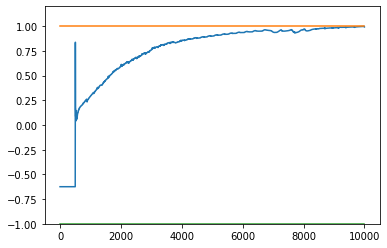

In [18]:
plt.plot(log['Epoch'].values, log['p3'].values)
plt.plot([0,10000],[1,1])
plt.ylim(-1,1.2)
plt.plot([0,10000],[-1,-1])

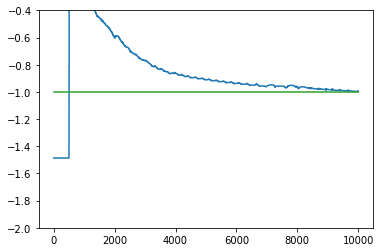

In [19]:
plt.plot(log['Epoch'], log['p4'])
plt.plot([0,10000],[1,1])
plt.ylim(-2,-0.4)
plt.plot([0,10000],[-1,-1])

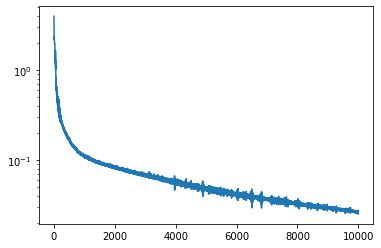

In [213]:
plt.semilogy(stat['epoch'], stat['loss_u'])

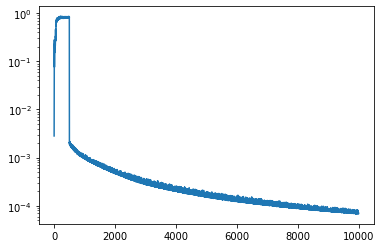

In [214]:
plt.semilogy(stat['epoch'], stat['loss_f'])

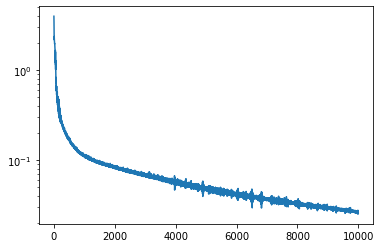

In [215]:
plt.semilogy(stat['epoch'], stat['loss_tot'])

In [10]:
t_mesh = dt*np.arange(nsteps)
x_mesh = dx*np.arange(nx)
y_mesh = dy*np.arange(ny)
t_mesh, x_mesh,y_mesh = np.meshgrid(t_mesh, x_mesh, y_mesh,indexing='ij')
t_mesh = np.reshape(t_mesh, (-1,1))
x_mesh = np.reshape(x_mesh, (-1,1))
y_mesh = np.reshape(y_mesh, (-1,1))
x_mesh /= x_max
y_mesh /= y_max
t_mesh /= t_max
prediction = model(torch.cat([torch.tensor(x_mesh), torch.tensor(y_mesh), torch.tensor(t_mesh)],dim=1).double().cuda(0))